In [272]:
import numpy as np
import matplotlib.pyplot as plt
from load import load_daily_generation_data

In [273]:
data = load_daily_generation_data('.\Data\gen_2021.csv')
day_of_week = np.array([ts.weekday() for ts in data['timestamps']])
month = np.array([ts.month - 1 for ts in data['timestamps']])

In [274]:
def normalize_series(series, normalization_const = None):
    series = np.array(series).reshape(-1, 1)
    series_min = np.min(series)
    if not normalization_const:
        normalization_const = np.max(series) - series_min
    return (series - series_min)/normalization_const

In [275]:
x = np.concatenate((normalize_series(day_of_week), normalize_series(month)), axis=1)
y_renewables = normalize_series(data['renewables'])
y_non_renewables = normalize_series(data['non_renewables'])

In [276]:
import GPy
GPy.plotting.change_plotting_library('plotly_offline')

In [277]:
def train_periodic_gp(x, y):
    input_dims = x.shape[1]
    kernel_rbf = GPy.kern.RBF(input_dim=input_dims)
    kernel_periodic = GPy.kern.StdPeriodic(input_dim=2, active_dims=[1, 2], period=1.0)
    kernel_white = GPy.kern.White(input_dim=input_dims)
    kernel_bias = GPy.kern.Bias(input_dim=input_dims)
    kernel = kernel_rbf + kernel_white + kernel_periodic + kernel_bias

    m = GPy.models.GPRegression(x, y,kernel)
    #m.Gaussian_noise.variance.constrain_bounded(0.01, 10)
    m.constrain_positive()

    m.optimize(messages=True)
    return m


In [278]:
x_prev_timestep_nr = np.concatenate((x[1:], y_non_renewables[:-1]), axis=1)
x_prev_timestep_r = np.concatenate((x[1:], y_renewables[:-1]), axis=1)
y_prev_timestep_nr = y_non_renewables[1:]
y_prev_timestep_r = y_renewables[1:]

In [279]:
model_nr = train_periodic_gp(x_prev_timestep_nr, y_prev_timestep_nr)
model_r = train_periodic_gp(x_prev_timestep_r, y_prev_timestep_r)

reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression


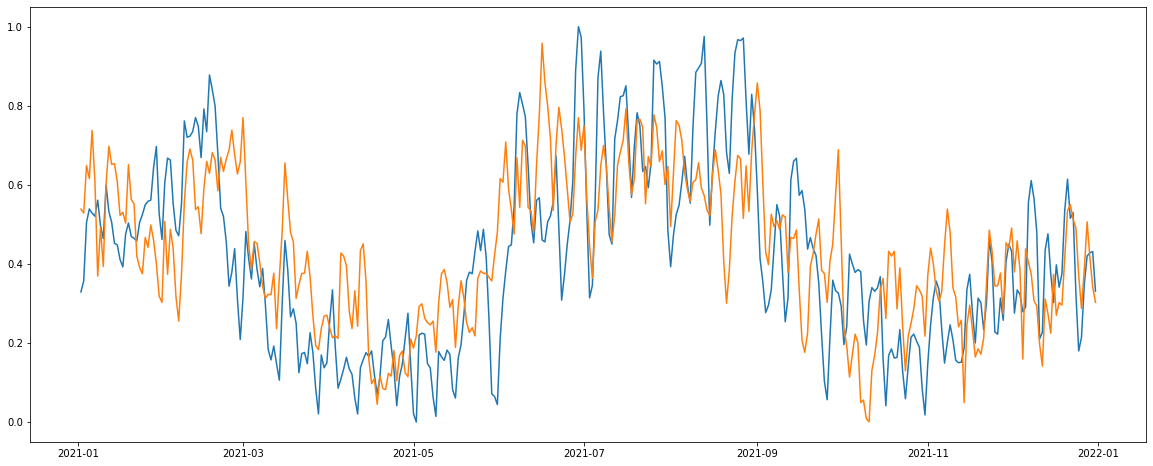

In [280]:
non_renewables_mean = np.mean(y_non_renewables)
non_renewables_var = np.var(y_non_renewables)

plt.plot(data['timestamps'], y_non_renewables)
plots = 1
for _ in range(plots):
    pred = np.array([np.random.normal(non_renewables_mean, non_renewables_var)])
    for day in x:
        input = np.concatenate((day.reshape(1,-1), np.array([pred[-1]]).reshape(1, 1)), axis=1)
        y = model_nr.posterior_samples(input, size=1)[0]
        pred = np.append(pred, y)
    plt.plot(data['timestamps'], pred[1:])
fig = plt.gcf()
fig.set_size_inches(20, 8)
plt.show()

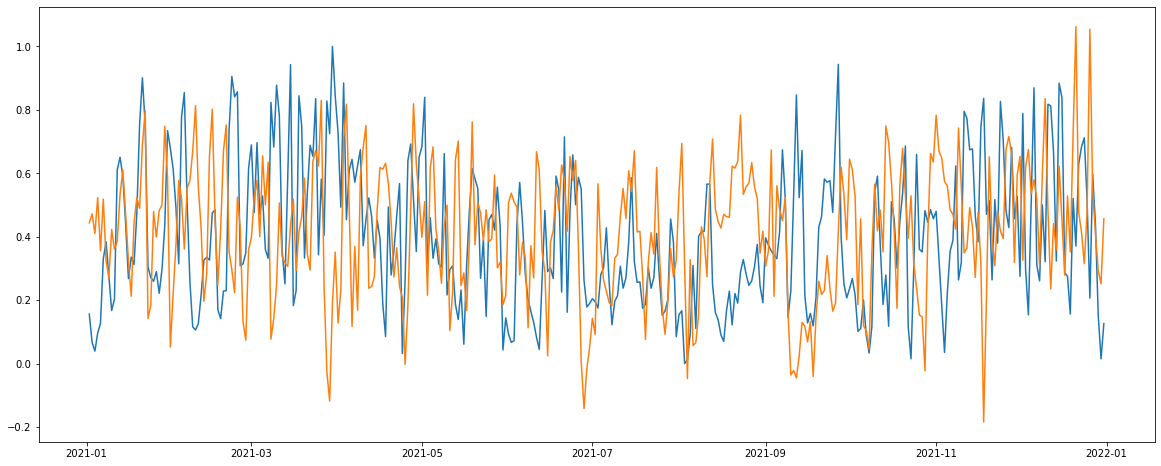

In [281]:
renewables_mean = np.mean(y_renewables)
renewables_var = np.var(y_renewables)

plt.plot(data['timestamps'], y_renewables)
plots = 1
for _ in range(plots):
    pred = np.array([np.random.normal(renewables_mean, renewables_var)])
    for day in x:
        input = np.concatenate((day.reshape(1,-1), np.array([pred[-1]]).reshape(1, 1)), axis=1)
        y = model_r.posterior_samples(input, size=1)[0]
        pred = np.append(pred, y)
    plt.plot(data['timestamps'], pred[1:])
fig = plt.gcf()
fig.set_size_inches(20, 8)
plt.show()

In [282]:
model_nr.save_model('supply-model-non-ren')
model_r.save_model('supply-model-ren')